In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import tikzplotlib

In [9]:
import pandas as pd

### Общие функции

In [2]:
def silhouette_score(data, partitioning):
    """
    [2]
    Вычисление внутренней метрики качества силуэт для заданного набора данных и его разбиения.
    
    Аргументы:
    data          -- заданный набор данных.
    partitioning  -- полученное тем или иным алгоритмом разбиение.
    
    Выходное значение:
    значение метрики.
    """
    s = [] # cписок вычисленных силуэтов для каждого элемента
    for elem in data:
        b = []
        for cluster in partitioning:
            if elem in cluster:
                ai = 1 / (len(cluster) - 1) if len(cluster) > 1 else 0
                ai_sum = 0
                for clelem in cluster:
                    if not np.array_equal(clelem, elem):
                        ai_sum += np.linalg.norm(clelem - elem)
                ai *= ai_sum
            else:
                bi = 1 / len(cluster)
                bi_sum = 0
                for clelem in cluster:
                    bi_sum += np.linalg.norm(clelem - elem)
                bi *= bi_sum
                b.append(bi)
        min_b = min(b) if b else 0
        s.append( (min_b - ai) / max(ai, min_b) )            
    return sum(s) / len(s)

In [3]:
def adjusted_rand_index(true, predict):
    """
    [2]
    Вычисление внешней метрики качества ARI между истинным разбиением и разбиением алгорима.
    
    Аргументы:
    true     -- истинное разбиение.
    predict  -- предсказанное разбиение.
    
    Выходное значение:
    значение метрики.
    """
    сontingency_matrix = [[0 for _ in range(len(predict))] for _ in range(len(true))]
    for i,true_cluster in enumerate(true):
        for j,predict_cluster in enumerate(predict):
            сontingency_matrix[i][j] = len(set(tuple(elem) for elem in true_cluster).intersection(set(tuple(elem) for elem in predict_cluster)))
    
    a = sum([math.comb(сontingency_matrix[i][j], 2) for i in range(len(true)) for j in range(len(predict))])
    b = sum([math.comb(len(cluster), 2) for cluster in true ])
    c = sum([math.comb(len(cluster), 2) for cluster in predict ])
    N = sum([len(cluster) for cluster in true])
    d = 2 * b * c / (N * (N - 1))
    
    return (a - d) / (0.5 * (b + c) - d)

In [4]:
def findBMU(mu_k, x): # best matching unit
    """
    Поиск наиболее близкого центра для элемента.
    
    Аргументы:
    mu_k -- массив центров.
    x    -- рассматриваемый элемент.
    
    Выходное значение:
    индекс кластера ближайшего центра.
    """
    return min([ (np.linalg.norm(x - mu), i)  for i, mu in enumerate(mu_k) ])[1]

In [5]:
def getPartitioning(data, mu_k, K):
    """
    Получить разбиение с текущими центрами
    
    Аргументы:
    data -- датасет.
    mu_k -- массив центров.
    K    -- количество кластеров.
    
    Выходное значение:
    разбиение.
    """
    clusters = [ [] for _ in range(K)]
        
    for elem in data: # определяем кластер каждого элемента выборки
        k = findBMU(mu_k, elem)
        clusters[k].append(elem)
    
    return [ np.array(clusters[i]) for i in range(K)]

In [6]:
def getRightWrongObjects(true, predict):
    """
    Получить количество верно и неверно классифицируемых объектов.
    
    Аргументы:
    true     -- истинное разбиение.
    predict  -- предсказанное разбиение.
    
    Выходное значение:
    количество верных и неверных объектов.
    """
    сontingency_matrix = [[0 for _ in range(len(predict))] for _ in range(len(true))]
    for i,true_cluster in enumerate(true):
        for j,predict_cluster in enumerate(predict):
            сontingency_matrix[i][j] = len(set(tuple(elem) for elem in true_cluster).intersection(set(tuple(elem) for elem in predict_cluster)))
    
    return sum([max(row) for row in сontingency_matrix]), sum([sum(row) - max(row) for row in сontingency_matrix])    

In [7]:
def k_means_fit(K, data, true_partitioning, tmax = 1000, scores = True, make_plots = True, make_table = True):
    """
    Обучение алгоритма - его реализация
    
    Аргументы:
    K                 -- желаемое количество кластеров.
    data              -- обучающий датасет.
    true_partitioning -- истинное разбиение. 
    tmax              -- количество итераций (default 1000). 
    scores            -- подсчет метрик (default True). 
    make_plots        -- вывод графиков (K=2, default True). 
    make_table        -- вывод сводной таблицы (default True).
    
    Выходное значение:
    вычисленные центры кластеров.
    """
    clusters = [ [] for _ in range(K)] # кластерные множества
    mu_k = [0] * K # центры
    len_data = len(data) # длина обучающей выборки
    partitioning = None
    if scores:
        silhouette = []
        ari = []
    if make_plots and K == 2:
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    if make_table:
        col_width = 0
    
    # рандомно инициализируем 'центры' случайными элементами из обучающей выборки
    for i in range(K):
        elem = data[np.random.choice(len_data)]
        while any([np.array_equal(e, elem) for e in mu_k[:i]]):
            elem = data[np.random.choice(len_data)]
        clusters[i].append(elem)
        mu_k[i] = clusters[i][-1]
        
    for i in range(tmax):
        # рассматриваем случайный элемент выборки
        ind = np.random.choice(len_data)
        x = np.copy(data[ind])
        
        # ищем ближайший 'центр'
        k = findBMU(mu_k, x)
        
        # если этого элемента нет в найденном кластере
        if not any([np.array_equal(elem, x) for elem in clusters[k]]): 
            clusters[k].append(x) # добавляем его в кластерное множество
        
            mu_k[k] = np.sum(clusters[k], axis = 0) / len(clusters[k]) # уточняем центр после добавления
                                                                        # усредняем
                
        if scores:
            partitioning = getPartitioning(data, mu_k, K)
            silhouette.append(silhouette_score(data, partitioning))
            ari.append(adjusted_rand_index(true_partitioning, partitioning))
        if not i % (tmax / 10):
            if partitioning is None:
                partitioning = getPartitioning(data, mu_k, K)
            if make_plots and K == 2:
                ax = axes[i // (tmax // 2), (i - (tmax // 2)) // (tmax // 10) if i // (tmax // 2) else i // (tmax // 10) ]
                ax.scatter(partitioning[0][:, 0], partitioning[0][:, 1], s = 15, marker = '>')
                ax.scatter(partitioning[1][:, 0], partitioning[1][:, 1], s = 15, c = 'green', marker = '<')
                ax.scatter(mu_k[0][0], mu_k[0][1], s = 35, marker = 'x', c = 'red')
                ax.scatter(mu_k[1][0], mu_k[1][1], s = 35, marker = 'x', c = 'red')
                ax.set_title(f'it={i + 1}')
                ax.grid()
            if make_table:
                if not i:
                    headers = ["Итерация", "Количество элементов в обучающей выборке", \
                               "Количестве правильно кластеризованных", "Количестве неправильно кластеризованных"]
                    if scores:
                        headers.append("Силуэт")
                        headers.append("ARI")
                    col_width = len(max(headers, key=len)) + 2
                    print(" | ".join(header.ljust(col_width) for header in headers))
                    print("-" * (len(headers) * (col_width + 2) - 1))
                
                row = [i + 1, len(data)]
                                
                right, wrong = getRightWrongObjects(true_partitioning, partitioning)
                
                row += [right, wrong]
                
                if scores:
                    row.append(silhouette[-1])
                    row.append(ari[-1])
                
                print(" | ".join(str(item).ljust(col_width) for item in row))
        
    if make_plots and K == 2:
        plt.tight_layout()
        tikzplotlib.save("iter.tex", flavor="context")
        plt.show()
    
    if scores:
        fig, axes = plt.subplots(1, 2, figsize=(15, 8))
        axes[0].plot(silhouette)
        axes[0].set_title('Silhouette')
        axes[0].grid()
        axes[1].plot(ari)
        axes[1].set_title('ARI')
        axes[1].grid()
        plt.tight_layout()
        tikzplotlib.save("metrics.tex", flavor="context")
        plt.show()
    
    return mu_k

In [8]:
def k_means_val(K, data, mu_k, true_partitioning):
    """
    Валидация на тестовых данных
    
    Аргументы:
    data              -- тестовый датасет.
    mu_k              -- массив центров.
    K                 -- количество кластеров.
    true_partitioning -- истинное разбиение.
    
    Выходное значение:
    строка с результатами на тесте.
    """
    partitioning = getPartitioning(data, mu_k, K)
    silhouette = silhouette_score(data, partitioning)
    ari = adjusted_rand_index(true_partitioning, partitioning)
    
    right, wrong = getRightWrongObjects(true_partitioning, partitioning)
    
    headers = ["Количество элементов в тестовой выборке", "Количестве правильно кластеризованных", \
               "Количестве неправильно кластеризованных", "Силуэт", "ARI"]
    row = [len(data), right, wrong, silhouette, ari]
    
    col_width = len(max(headers, key=len)) + 2
    return " | ".join(header.ljust(col_width) for header in headers) + "\n"\
            "" + " | ".join(str(item).ljust(col_width) for item in row)

### Синтетические данные

In [4]:
def make_blobs_two(N: int, mu1: tuple, mu2: tuple, sigma1: tuple, sigma2: tuple, \
                   make_plot=True, tikz=True, silhouette=True, cent=True):
    """
    Генерация смеси из двух гауссовых распределений
    
    Аргументы:
    N              -- количество элементов в распределении.
    mu1, mu2       -- кортежи мат. ож. распределений.
    sigma1, sigma2 -- кортежи ср. кв. отклонений.
    make_plot      -- вывод графика (default True).
    tikz           -- сохранение выведенного графика в формате tikz (make_plot=True, default True).
    silhouette     -- вывод силуэта сгенерированного распределения (default True).
    cent           -- вывод на графике положений центров (мат. ож.) (default True).
    
    Выходное значение:
    data_set       -- сгенерированный датасет.
    clusters       -- истинное разбиение.
    """
    x1, y1 = np.random.normal(mu1[0], sigma1[0], N), np.random.normal(mu1[1], sigma1[1], N)
    x2, y2 = np.random.normal(mu2[0], sigma2[0], N), np.random.normal(mu2[1], sigma2[1], N)

    if make_plot:
        plt.scatter(x1, y1, s = 20, marker = '>')
        plt.scatter(x2, y2, s = 20, c = 'green', marker = '<')
        if cent:
            plt.scatter([mu1[0], mu2[0]], [mu1[1], mu2[1]], s = 40, marker = 'x', c = 'red')
        plt.grid()
        if tikz:
            filename = input("Input .tex filename: ")
            tikzplotlib.save(f"{filename}.tex", flavor="context")
        plt.show()
    
    clusters = [np.c_[x1, y1], np.c_[x2, y2]]
    data_set = np.concatenate(clusters)
    np.random.shuffle(data_set)
    if silhouette:
        print(f"Silhouette of generated dataset: {silhouette_score(data_set, clusters)}")
    
    return data_set, clusters

Input .tex filename: train


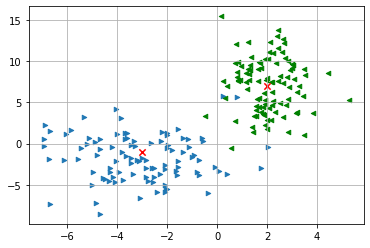

Silhouette of generated dataset: 0.5890167323812049


In [5]:
train_set, train_partitioning = make_blobs_two(100, (-3, -1), (2, 7), (2, 3), (1, 3))

Input .tex filename: test


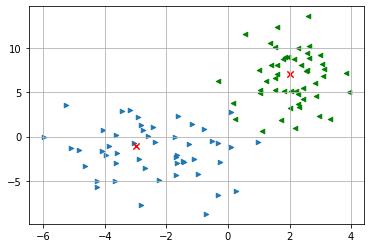

Silhouette of generated dataset: 0.5703875093994177


In [6]:
test_set, test_partitioning = make_blobs_two(50, (-3, -1), (2, 7), (2, 3), (1, 3))

Итерация                                   | Количество элементов в обучающей выборке   | Количестве правильно кластеризованных      | Количестве неправильно кластеризованных    | Силуэт                                     | ARI                                       
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1                                          | 200                                        | 187                                        | 13                                         | 0.5589742412373719                         | 0.7556930746820094                        
11                                         | 200                                        | 180                                        | 20                                         | 0.5247072369215684  

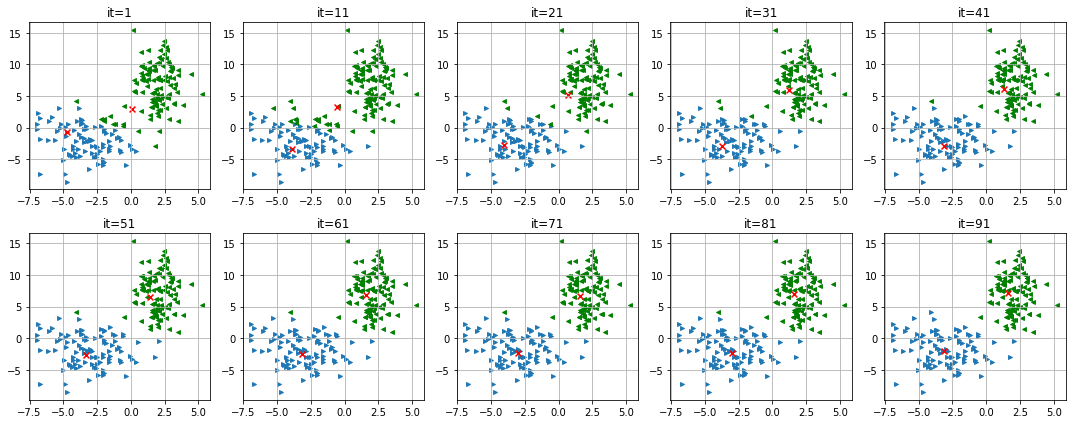

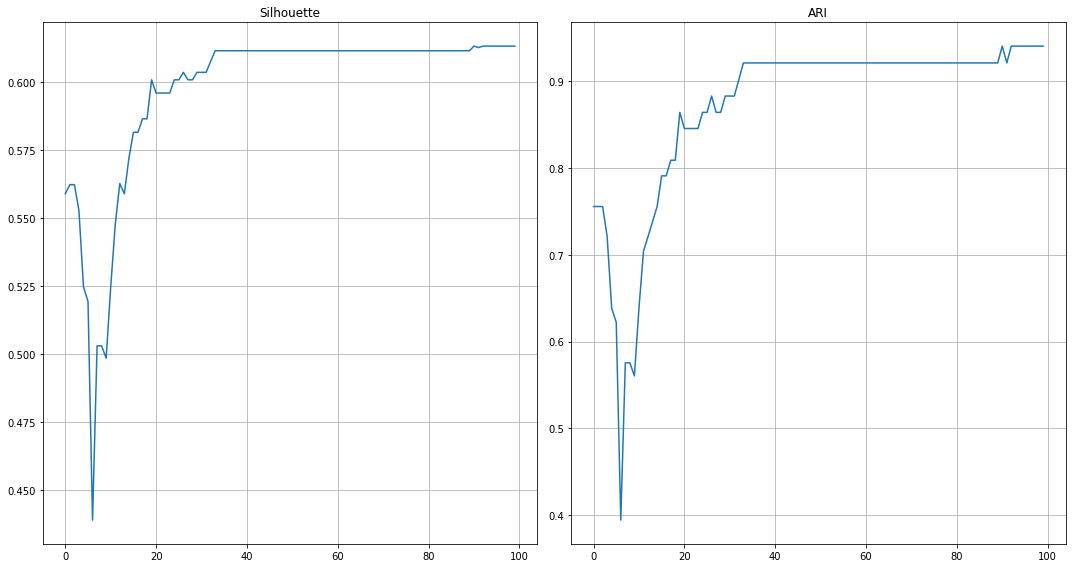

In [16]:
mu_k = k_means_fit(2, train_set, train_partitioning, tmax=100)

In [12]:
print("Запуск 1: ", mu_k)

Запуск 1:  [array([2.09153588, 7.40263936]), array([-3.0592664 , -1.65848448])]


In [14]:
print("Запуск 2: ", mu_k)

Запуск 2:  [array([-2.34105203, -1.89564925]), array([1.96439118, 7.16484518])]


In [17]:
print("Запуск 3: ", mu_k)

Запуск 3:  [array([-3.12591619, -1.9838017 ]), array([1.7306766, 7.0221724])]


In [30]:
print(k_means_val(2, test_set, mu_k, test_partitioning))

Количество элементов в тестовой выборке   | Количестве правильно кластеризованных     | Количестве неправильно кластеризованных   | Силуэт                                    | ARI                                      
100                                       | 97                                        | 3                                         | 0.5822926878803871                        | 0.8824127248460211                       


### Реальные данные

In [1]:
def normalize(data):
    """
    Нормализация данных так, чтобы каждый столбец содержал 0, 1 и значения из интервала (0, 1).
    
    Аргументы:
    data -- набор ненормализованных данных.
    
    Выходное значение:
    нормализованный набор данных.
    """
    for n in range(len(data[0])):
        max_n, min_n = max(data[:, n]), min(data[:, n])
        k, b = 1 / (max_n - min_n), -min_n / (max_n - min_n)
        for m in range(len(data)):
            data[m, n] *= k
            data[m, n] += b
    return data

In [24]:
def load_set(names: list, set_type='train', make_plot=True, norm=True, balanced=False,\
             silhouette=True, statistic=True, cent=False):
    """
    Загрузка данных из .csv
    
    Аргументы:
    names      -- наименования классов.
    set_type   -- тип загружаемого датасета (train, test) (default train).
    make_plot  -- вывод графика (default True).
    silhouette -- вывод силуэта сгенерированного распределения (default True).
    cent       -- вывод на графике положений центров (мат. ож.) (default True).
    norm       -- нормализация данных (default True).
    balanced   -- сбалансировать обучающую выборку (set_type = train, default False)
    statistic  -- вывести количество объектов по классам.
    
    Выходное значение:
    data_set   -- сгенерированный датасет.
    clusters   -- истинное разбиение.
    """
    if set_type != 'train':
        set_type = 'test'
        
    set_df = pd.read_csv(f'{set_type}.csv')
    data_set = np.array(set_df.iloc[:, :-1])
    labels = np.array(set_df.iloc[:, -1])
    
    if norm:
        data_set = normalize(data_set)
        set_df.iloc[:, :-1] = pd.DataFrame(data_set)
    
    if make_plot and norm:
        x = pd.plotting.andrews_curves(set_df.sample(frac=1, random_state=42).iloc[:50],\
                                       list(set_df.columns)[-1], color=['black', 'cyan', 'green'])
        tikzplotlib.save(f"andrews_{set_type}.tex", flavor="context")
        plt.show()
    
    clusters = [[] for _ in range(len(names))]
    for i, label in enumerate(labels): 
        clusters[names.index(label)].append(data_set[i].copy())
        
    if set_type == 'train' and balanced:
        min_cl_len = len(min(clusters, key=len))
        for i in range(len(clusters)):
            clusters[i] = clusters[i][:min_cl_len]
        data_set = np.array([ elem for cluster in clusters for elem in cluster ])
    
    clusters = [np.array(cluster) for cluster in clusters]
    np.random.shuffle(data_set)
        
    if silhouette:
        print(f"Silhouette of load {set_type} dataset: {silhouette_score(data_set, clusters)}")
    
    if statistic:
        print(f"In {set_type} dataset ...")
        for i, name in enumerate(names):
            print(f"{name} - {len(clusters[i])} instances;")
        print(f"ALL - {len(data_set)} instances")
    
    if set_type == 'train' and cent:
        print(f"Expected centroids ...")
        for i, name in enumerate(names):
            print(f"{name} - {np.sum(clusters[i], axis = 0) / len(clusters[i])}")
            
    return data_set, clusters

In [36]:
def getRightWrongObjectsPerClass(true, predict, names):
    """
    Получить количество верно и неверно классифицируемых объектов в каждом классе
    
    Аргументы:
    true     -- истинное разбиение.
    predict  -- предсказанное разбиение.
    names    -- наименования классов.
    
    Выходное значение:
    результирующая строка.
    """
    сontingency_matrix = [[0 for _ in range(len(predict))] for _ in range(len(true))]
    for i,true_cluster in enumerate(true):
        for j,predict_cluster in enumerate(predict):
            сontingency_matrix[i][j] = len(set(tuple(elem) for elem in true_cluster).intersection(set(tuple(elem) for elem in predict_cluster)))
    
    result = []
    [ result.append(f"{names[i]} : {max(row)}, {sum(row) - max(row)}") for i,row in enumerate(сontingency_matrix)]
    return '\n'.join(result)

In [10]:
class_names = ['Kama', 'Rosa', 'Canadian']

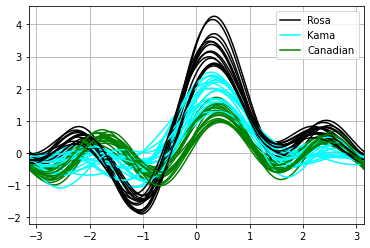

Silhouette of load train dataset: 0.4547819362625533
In train dataset ...
Kama - 50 instances;
Rosa - 50 instances;
Canadian - 50 instances;
ALL - 150 instances
Expected centroids ...
Kama - [0.37605288 0.40958678 0.67898367 0.36146396 0.46152299 0.28463567
 0.24108364]
Rosa - [0.76932956 0.80747934 0.68317604 0.74752252 0.77316092 0.42296232
 0.75613887]
Canadian - [0.11004721 0.1718595  0.30606171 0.19948198 0.12152299 0.60395627
 0.27080484]


In [25]:
train_set, train_partitioning = load_set(class_names, cent=True)

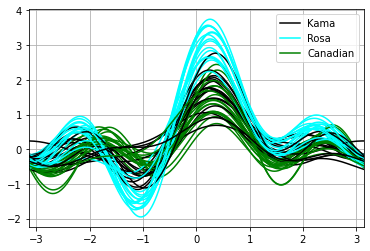

Silhouette of load test dataset: 0.34693373416026885
In test dataset ...
Kama - 20 instances;
Rosa - 20 instances;
Canadian - 20 instances;
ALL - 60 instances


In [26]:
test_set, test_partitioning = load_set(class_names, set_type = 'test')

Итерация                                   | Количество элементов в обучающей выборке   | Количестве правильно кластеризованных      | Количестве неправильно кластеризованных    | Силуэт                                     | ARI                                       
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1                                          | 150                                        | 135                                        | 15                                         | 0.4307520384869524                         | 0.731385132522962                         
11                                         | 150                                        | 135                                        | 15                                         | 0.44423191106171817 

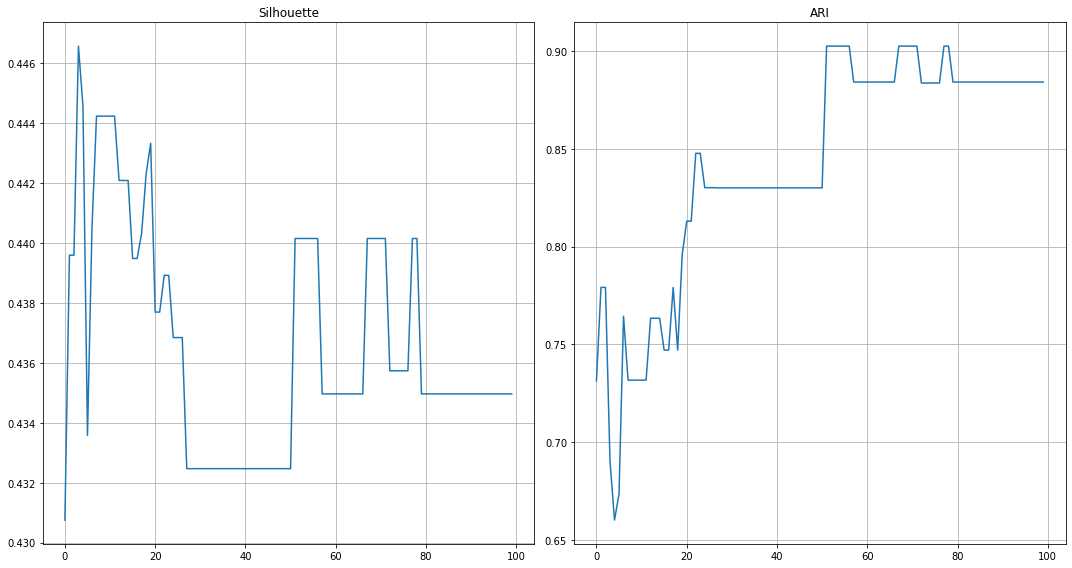

In [31]:
mu_k = k_means_fit(3, train_set, train_partitioning, tmax=100, make_plots = False)

In [28]:
print("Запуск 1: ", mu_k)

Запуск 1:  [array([0.12602298, 0.18224862, 0.3505369 , 0.19664977, 0.15367577,
       0.56845789, 0.25640014]), array([0.74364355, 0.78634833, 0.66538953, 0.72864531, 0.73930396,
       0.41424832, 0.73559725]), array([0.41377479, 0.44757231, 0.69271779, 0.39833193, 0.50188578,
       0.25956054, 0.28245003])]


In [30]:
print("Запуск 2: ", mu_k)

Запуск 2:  [array([0.08362187, 0.14807163, 0.25599919, 0.19963714, 0.09115581,
       0.7288349 , 0.27272196]), array([0.72859887, 0.77001995, 0.67253896, 0.71264368, 0.748043  ,
       0.40976929, 0.705001  ]), array([0.27699987, 0.31847698, 0.56554317, 0.29412806, 0.33667898,
       0.34670308, 0.247088  ])]


In [32]:
print("Запуск 3: ", mu_k)

Запуск 3:  [array([0.40931697, 0.43987603, 0.70804598, 0.38404655, 0.49748563,
       0.35286906, 0.29018061]), array([0.75584021, 0.79599353, 0.67624083, 0.74255778, 0.75259245,
       0.44042219, 0.76147565]), array([0.11012748, 0.17501722, 0.2895493 , 0.19545327, 0.11787596,
       0.57559046, 0.26422497])]


In [33]:
print(k_means_val(3, test_set, mu_k, test_partitioning))

Количество элементов в тестовой выборке   | Количестве правильно кластеризованных     | Количестве неправильно кластеризованных   | Силуэт                                    | ARI                                      
60                                        | 49                                        | 11                                        | 0.38002199207027143                       | 0.5395763656633222                       


In [38]:
print(getRightWrongObjectsPerClass(train_partitioning, getPartitioning(train_set, mu_k, 3), class_names))

Kama : 45, 5
Rosa : 49, 1
Canadian : 50, 0


In [39]:
print(getRightWrongObjectsPerClass(test_partitioning, getPartitioning(test_set, mu_k, 3), class_names))

Kama : 16, 4
Rosa : 18, 2
Canadian : 15, 5
